In [2]:
using LightGraphs, GraphPlot

In [17]:
"Read a space separated file into an (undirected) Graph in an efficient way."
function readnetwork(filename::String, limit::Number = Inf; fromzero::Bool = false)
    #edges = parse(readstring(pipeline(`grep -v '^#' $filename`, `wc -l`)))
    
    graph = Graph()
    vertices = 0
    correction = Int(fromzero)
    
    # using grep to exclude comment lines
    open(`grep -v '^#' $filename`) do file
        for (l, line) in enumerate(eachline(file))
            if l > limit
                break
            end

            a, b = map(e -> parse(e) + correction, matchall(r"\d+", line))
            
            if a > vertices || b > vertices
                @assert add_vertices!(graph, max(a, b) - vertices)
                vertices = max(a, b)
            end
            
        #print("$graph, $a, $b\n")
        
        # we explicitely ignore inverse directions, if there are any
        @assert has_edge(graph, a, b) || add_edge!(graph, a, b)
        end
    end

    return graph
end

readnetwork

In [18]:
roads_europe = readnetwork("roads-europe.txt")

{1174, 1417} undirected graph

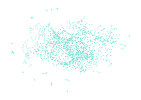

In [19]:
gplot(roads_europe)

In [23]:
components_europe = connected_components(roads_europe)

26-element Array{Array{Int64,1},1}:
 [1,2,3,4,5,15,16,17,18,19  …  627,821,822,823,838,839,840,841,855,861]           
 [6,7,8,9,10,11,12,13,14,22  …  1159,1164,1165,1166,1167,1168,1169,1170,1171,1172]
 [58,59,60]                                                                       
 [61,62,63,1144]                                                                  
 [125,126,127,128,572,573,1160,1161]                                              
 [213,214,249,250,251]                                                            
 [355,356]                                                                        
 [365,366,367,379,380,381,382,586,587,588,589,590,812,820,986]                    
 [646,647,648]                                                                    
 [653,654,655,656]                                                                
 [776,777,778,779,780]                                                            
 [924,925,926,927]                                 

In [24]:
[(c, length(c)) for c in components_europe]

26-element Array{Tuple{Array{Int64,1},Int64},1}:
 ([1,2,3,4,5,15,16,17,18,19  …  627,821,822,823,838,839,840,841,855,861],39)             
 ([6,7,8,9,10,11,12,13,14,22  …  1159,1164,1165,1166,1167,1168,1169,1170,1171,1172],1039)
 ([58,59,60],3)                                                                          
 ([61,62,63,1144],4)                                                                     
 ([125,126,127,128,572,573,1160,1161],8)                                                 
 ([213,214,249,250,251],5)                                                               
 ([355,356],2)                                                                           
 ([365,366,367,379,380,381,382,586,587,588,589,590,812,820,986],15)                      
 ([646,647,648],3)                                                                       
 ([653,654,655,656],4)                                                                   
 ([776,777,778,779,780],5)                         

In [21]:
roads_texas = readnetwork("roads-texas.txt", 100_000; fromzero = true)

{1373945, 50371} undirected graph

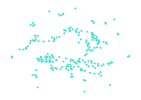

In [22]:
gplot(roads_texas[1:200])

In [6]:
ccs = connected_components(g)

21

In [10]:
large_comps = sort(filter(a -> length(a) > 1, ccs), by=length, rev=true)
map(length, large_comps)

21-element Array{Int64,1}:
 12363
 12331
  7489
  4999
   196
    29
    24
    19
    16
     9
     4
     4
     2
     2
     2
     2
     2
     2
     2
     2
     2

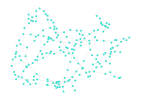

In [12]:
gplot(g[large_comps[5]])

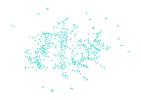

In [14]:
gplot(g[large_comps[4][1:400]])

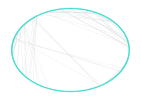

In [17]:
gplot(g[large_comps[4][1:400]], layout=shell_layout)